#  Working with LIGO Data
(This notebook was adapted from [Tutorial 1.2](https://github.com/gw-odw/odw-2020/blob/master/Day_1/Tuto%201.2%20Open%20Data%20access%20with%20GWpy.ipynb) from the Open Data Workshop \#3)

In the previous notebook, we talked about the properties of waves, and how you can convert between the time and frequency representations for discretely-sampled data. Now, we will see how this applies to real LIGO data. We will use a few pre-packaged python modules specifically for processing and accessing gravitational-wave data. First, we need to install these packages:

In [ ]:
# -- Uncomment following line if running in Google Colab
#! pip install -q 'gwpy==1.0.1'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [1]:
%pylab inline
import gwpy
print(gwpy.__version__)

Populating the interactive namespace from numpy and matplotlib
2.0.2


## A note on object-oriented programming

Before we dive too deeply, its worth a quick aside on object-oriented programming (OOP).
GWpy is heavily object-oriented, meaning almost all of the code you run using GWpy is based around an object of some type, e.g. `TimeSeries`.
Most of the methods (functions) we will use are attached to an object, rather than standing alone, meaning you should have a pretty good idea of what sort of data you are dealing with (without having to read the documentation!).

For a quick overview of object-oriented programming in Python, see [this blog post by Jeff Knupp](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/).

## Handling data in the time domain
#### Finding open data
When the LIGO-Virgo Collaboration publishes the detection of a new event, they usually also release the data surrounding the time of the detection. These data are stored on the Gravitational-Wave Open Science Center, or [GWOSC.](https://www.gw-openscience.org/about/) The `gwosc` module can be used to query for what data are available on GWOSC. Let's try to download the data for GW150914, the first direct detection of an astrophysical gravitational-wave signal from a BBH (binary black hole system).

We can use the [`TimeSeries.fetch_open_data`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.fetch_open_data) method to download data directly from https://www.gw-openscience.org, but we need to know the GPS times.
We can query for the GPS time of an event as follows:

In [2]:
from gwosc.datasets import event_gps
gps = event_gps('GW150914')
print(gps)

1126259462.4


Now we can build a `(start, end)` GPS segment to include 10 seconds around this time, using integers for convenience. This data type, which has two elements, is called a _tuple_ in python.

In [3]:
segment = (int(gps)-5, int(gps)+5)
print(segment)

(1126259457, 1126259467)


Now we can query for the full dataset. For this example we choose to retrieve data for the LIGO-Livingston interferometer, using the identifier `'L1'`. This observatory is located in Louisiana. 
We could have chosen any of

- `'G1`' - GEO600
- `'H1'` - LIGO-Hanford
- `'L1'` - LIGO-Livingston
- `'V1'` - (Advanced) Virgo

In the future, the Japanese observatory KAGRA will come online, with the identifier `'K1'`.

In [4]:
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
print(hdata)

Fetched 1 URLs from www.gw-openscience.org for [1126259457 .. 1126259467))
Reading data... [Done]
TimeSeries([-9.31087178e-19, -9.75697062e-19, -1.01074940e-18,
            ..., -1.13460681e-18, -1.11414494e-18,
            -1.15931435e-18]
           unit: dimensionless,
           t0: 1126259457.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


In the call to the method `fetch_open_data` above, the operator `*` unpacks the two elements stored in the `segment` variable. **The `verbose=True` flag lets us see that GWpy has discovered two files that provide the data for the given interval, downloaded them, and loaded the data.**
The files are not stored permanently, so next time you do the same call, it will be downloaded again; however, if you know you might repeat the same call many times, you can use `cache=True` to store the file on your computer or in the cloud on Google collab.

We have now downloaded real LIGO data for GW150914! These are the actual data used in the analysis that discovered the first binary black hole merger. To sanity check things, we can easily make a plot, using the [`plot()`](https://gwpy.github.io/docs/stable/timeseries/plot.html) method of the `data` `TimeSeries`. How does this plot compare to those of the $\sin(t)$ functions we plotted in the last notebook?

Text(0, 0.5, 'h(t)')

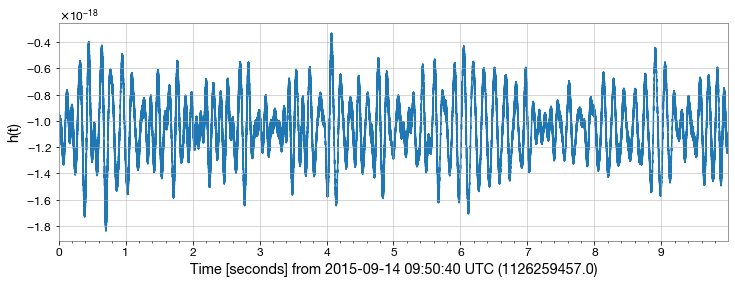

In [5]:
plot = hdata.plot()
plt.ylabel('h(t)')

The `hdata` object has several methods that we can use to learn more about this data. [Here](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#timeseries) is full list of all the attributes and methods of this object type. Let's print the $\Delta t$, sampling rate, duration, and the associated array of times:

In [6]:
print('Duration: {}'.format(hdata.duration))
print('dt: {}'.format(hdata.dt))
print('Sampling rate: {}'.format(hdata.sample_rate))
# confirm that sampling_rate = 1/dt
print('Sampling rate: {}'.format(1./hdata.dt))
hdata.times

Duration: 10.0 s
dt: 0.000244140625 s
Sampling rate: 4096.0 Hz
Sampling rate: 4096.0 1 / s


<Index [1.12625946e+09, 1.12625946e+09, 1.12625946e+09, ...,
        1.12625947e+09, 1.12625947e+09, 1.12625947e+09] s>

## Handling data in the frequency domain using the Fourier transform

As we saw in the last notebook, the [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) is a widely-used mathematical tool to expose the frequency-domain content of a time-domain signal, meaning we can see which frequencies contian lots of power, and which have less.

We can calculate the Fourier transform of our `TimeSeries` using the [`fft()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.fft) method:

In [7]:
fft = hdata.fft()
print(fft)

FrequencySeries([-1.05219333e-18+0.00000000e+00j,
                 -9.36314427e-22+6.61514979e-23j,
                 -8.74693847e-22-3.26717194e-23j, ...,
                  6.63325463e-24-1.10870240e-26j,
                  6.73663868e-24-7.82178218e-26j,
                  6.69598891e-24+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1126259457.0,
                name: Strain,
                channel: None)


The result is a [`FrequencySeries`](https://gwpy.github.io/docs/stable/frequencyseries/), with complex amplitude, representing the amplitude and phase of each frequency in our data. The data $h(f)$ has both a real and a complex component:
$$h(f) = h_\mathrm{Re}(f) + ih_{\mathrm{Im}}(f)$$
We can't plot both of these components at the same time on a 2D plot, and we are generally interested in the overall amplitude:
$$h_\mathrm{Amp}(f) = \sqrt{h_\mathrm{Re}^{2}(f) + h_{\mathrm{Im}}^{2}(f)}$$
We can use `abs()` to extract the amplitude and plot that:

/opt/anaconda3/envs/igwn-py38/lib/python3.8/site-packages/gwpy/plot/plot.py:276: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


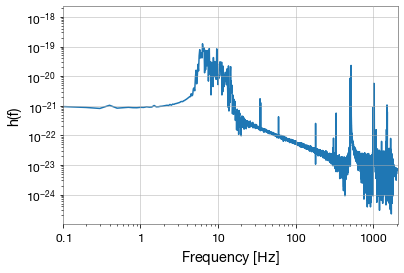

In [8]:
plot = fft.abs().plot(xscale="log", yscale="log")
plt.ylabel('h(f)')
plot.show(warn=False)

We are missing one key step to get back a sensible-looking Fourier transform. When we did this on sine and cosine functions in the previous notebook, our data was periodic, meaning that if you wrapped the end around to the beginning, there would be no discontinuities. However, this is not true for real gravitational-wave data. The 10-second chunk of data we've loaded here does not repeat indefinitely. The next 10-second chunk of data would look completely different. We need to apply a window function to our time-domain data before transforming, which deals with the discontinuities by tapering the data at the start and end of the segment. Different window functions have different tapering shapes. Let's look at two typical windows used for gravitational-wave data, the Hann and Tukey windows. We can generate these windows using the [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html) module.

Text(0, 0.5, 'window')

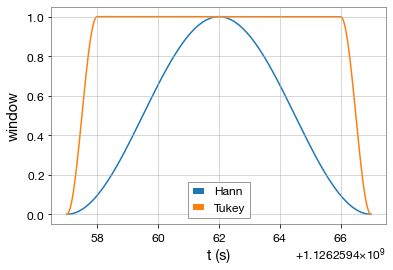

In [9]:
from scipy.signal import get_window
window = get_window('hann', hdata.size)
plt.plot(hdata.times, window, label='Hann')
window_tukey = get_window(('tukey',0.2), hdata.size)
plt.plot(hdata.times, window_tukey, label='Tukey')
plt.legend()
plt.xlabel('t (s)')
plt.ylabel('window')

The fact that the beginning and end values of the window functions go to zero allows us to approximate the LIGO data as periodic once we've multiplied them by the window function. How quickly the window goes from zero to one is set by the type of window and in the case of the tukey window, the second parameter passed in `('tukey',0.2)`. Can you adjust the value of 0.2 so that the Tukey window and the Hann window overlap? What does this parameter represent?

Let's take a look at our windowed data:

/opt/anaconda3/envs/igwn-py38/lib/python3.8/site-packages/gwpy/plot/plot.py:276: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


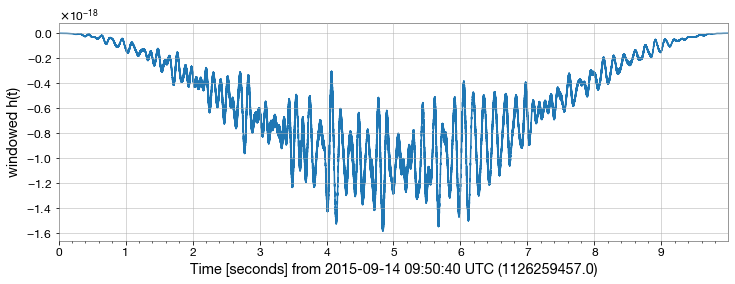

In [10]:
hwin = hdata * window
plot = hwin.plot()
plt.ylabel('windowed h(t)')
plot.show()

The data look completely different! Let's try our transform again and see what we get

/opt/anaconda3/envs/igwn-py38/lib/python3.8/site-packages/gwpy/plot/plot.py:276: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


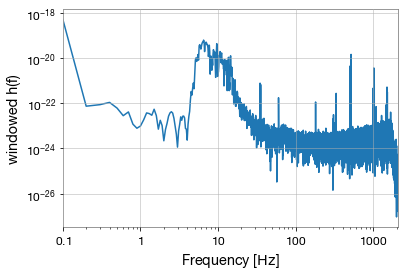

In [11]:
fftamp = hwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
plt.ylabel('windowed h(f)')
plot.show(warn=False)

What is happening at low frequencies? Gravitational-wave detectors have very limited sensitivity at low frequencies due to **seismic noise**, which basically just means ground motion. The natural shaking of the earth at these frequencies interferes with our ability to detect gravitational-waves there, so the data below about 10 Hz are usually discarded as unreliable.

## The power spectral density
LIGO data can be characterized by a quantity called the "Power Spectral Density", or PSD. This is a frequency-dependent quantity that describes how sensitive the detector is. The lower the PSD, the more sensitive the detector. 
$$ \mathrm{PSD}(f) = \langle h(f)^{*}h(f) \rangle $$

In the notation above, the brackets denote an average over the frequency-domain data from many segments. The operator $^{*}$ denotes the complex conjugate. For a complex number $a = b + ic$, the complex conjugate just switches the sign of the negative part, so $a^{*} = b - ic$. We can use the numpy functions `np.real` and `np.imag` to find the real and imaginary parts of our data. Add a new cell and calculate the complex conjugate of `hdata` below.

In [12]:
h_conjugate = np.real(hdata) - np.imag(hdata)
print(h_conjugate)

TimeSeries([-9.31087178e-19, -9.75697062e-19, -1.01074940e-18,
            ..., -1.13460681e-18, -1.11414494e-18,
            -1.15931435e-18]
           unit: dimensionless,
           t0: 1126259457.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


In practice, we typically use a large number of FFTs to estimate an average power spectral density over a long period of data. A longer stretch of data is divided into individual segments, the value of $n(f)^{*}n(f)$ is calculated for each segment, and the final estimated PSD is the average of those from individual segments. The more segments you average, the better the resolution of your PSD will be. Let's try this out. We will break our data into overlapping 4-second segments. The first segment will cover seconds 0-4, the second 2-6, the third 4-8, and the fourth 6-10.

In [13]:
sampling_rate = int(hdata.sample_rate.value)
len_segment = 4*sampling_rate #number of elements in each segment
h0 = hdata[0:len_segment]
h1 = hdata[2*sampling_rate:2*sampling_rate+len_segment]
h2 = hdata[4*sampling_rate:4*sampling_rate+len_segment]
h3 = hdata[6*sampling_rate:6*sampling_rate+len_segment]
segment_list = [h0, h1, h2, h3]

Now we need to window each of our segments. We'll use a `for` loop for this:

In [14]:
window = get_window('hann', len_segment)
windowed = []
for data in segment_list:
    windowed.append(data*window)

Now we need to take the FFT of each data segment:

In [15]:
fft_list = []
for data in windowed:
    fft_list.append(data.fft())

Next, we multiply each of the indiviudal segment $n(f)$s by their complex conjugate. We can use the `np.conjugate()` function for this, which does exactly the operation we performed above using `np.real` and `np.imag`.

In [16]:
psd_list = []
for data in fft_list:
    psd_list.append(np.conjugate(data)*data)

Finally, we average the $n(f)^{*}n(f)$ we have computed for each segment. We use a median average.

In [17]:
psd = np.median(psd_list, axis=0)

Now let's plot the resulting PSD that we just calculated:

/opt/anaconda3/envs/igwn-py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(10, 1024)

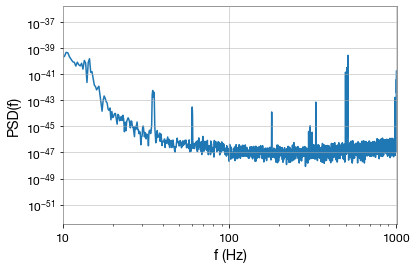

In [18]:
segment_df = 1./4
segment_frequencies = np.arange(0, sampling_rate/2, segment_df)
plt.loglog(segment_frequencies, psd[:-1])
plt.xlabel('f (Hz)')
plt.ylabel('PSD(f)')
plt.xlim(10, 1024)

This type of averaging that we've just performed is called [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method) for calculating the PSD. We can also do this using the [`psd()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.asd) method from `gwpy`.

/opt/anaconda3/envs/igwn-py38/lib/python3.8/site-packages/gwpy/plot/plot.py:276: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


(10, 1024)

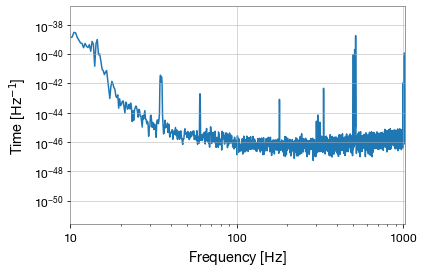

In [19]:
psd_gwpy = hdata.psd(fftlength=4, method="median")
plot = psd_gwpy.plot()
plot.show(warn=False)
plt.xlim(10, 1024)

What happens if you make the `fftlength` variable above longer or shorter? This sets the length of the individual segments that are being averaged over.
For the LIGO-Hanford data we loaded, we can see large spikes at certain frequencies, including

- ~300 Hz
- ~500 Hz
- ~1000 Hz

The [O2 spectral lines](https://www.gw-openscience.org/o2speclines/) page on GWOSC describes a number of these spectral features for O2, with some of them being forced upon us, and some being deliberately introduced to help with interferometer control.

Loading more data allows for more FFTs to be averaged during the PSD calculation, meaning random variations get averaged out, and we can see more detail. Let's load a 1024-second segment of data from the LIGO Hanford detector around the time of the GW150914 event we looked at above.

/opt/anaconda3/envs/igwn-py38/lib/python3.8/site-packages/gwpy/plot/plot.py:276: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


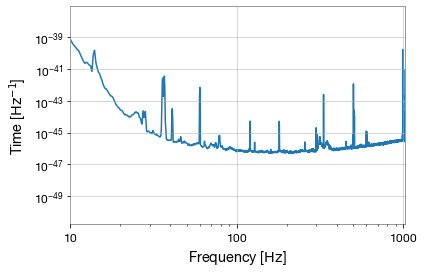

In [20]:
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hpsd2 = hdata2.psd(fftlength=4, method="median")
plot = hpsd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1024)
plot.show(warn=False)

Now we can see some more features, including sets of lines around ~30 Hz and ~65 Hz, and some more isolated lines through the more sensitive region.

For comparison, we can load the LIGO-Livingston data and plot that as well:

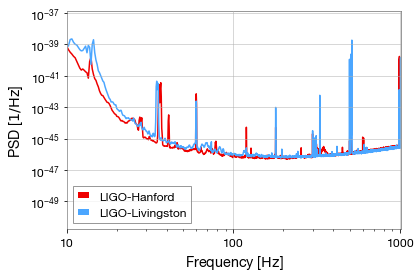

In [21]:
# get Livingston data
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lpsd2 = ldata2.psd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(lpsd2, label='LIGO-Livingston', color='gwpy:ligo-livingston')

# update the Hanford line to use standard colour, and have a label
hline = ax.lines[0]
hline.set_color('gwpy:ligo-hanford')  # change colour of Hanford data
hline.set_label('LIGO-Hanford')

ax.set_ylabel(r'PSD [$1/\mathrm{Hz}$]')
ax.legend()
plot

Now we can see clearly the relative sensitivity of each LIGO instrument, the common features between both, and those unique to each observatory. Which instrument is more sensitive at low frequencies, below 100 Hz?

### Challenge Question 1:

The peak amplitude in the LIGO-Livingston time-series data occurs at approximately 5 seconds into the plot above and is undetectable above the background noise by the eye. Plot the timeseries data for the LIGO-Hanford detector around GW150914 using the same 10-second segment. Looking at your new LIGO-Handford plot, can your eye identify a signal peak? 

### Challenge Question 2 :

Make an PSD around the time of an O3 event, GW190412 for L1 detector .  Compare this with the ASDs around GW150914 for L1 detector.  Which data have lower noise - and so are more sensitive - around 100 Hz?
